In [870]:
# Goals of project: determine high vaue case types and subject areas

In [2158]:
# Assumptions:
#  1. Include only searches that are completed, underway or terminated. 
#  2. Data not to be included:
    # -SN
    # -'Not litigation' (inbound requests)
    # -'Pro Bono' (inbound requests)
#  3. Based on results from 'Christophers report for Jan20 through Oct24' analysis
    # -investigate IP separately across subject areas
    # -group antitrust, false claims act and criminal 
    # -group class action, tort, contract and unfiled 

In [2046]:
import pandas as pd
# using report generated 11/13/2024 'all_searches_created_after_january_2020.csv' includes hours info from 2020 through 10/2024
months=57
df = pd.read_csv('all_searches_created_after_january_2020.csv')
df.head()
df.nunique()

Record Id              2925
Record Id.1           10814
Search Name            2925
Srch Created           1098
Type of Case             10
Subject                  23
Case Mgr                  6
Primary Law Firm        862
Search Stage              9
Search Failed Date      783
K Date                  761
Hours Reported         1158
Source                    2
Division                  2
NOS                      51
Clone?                    2
Billing Date             58
Last Billed Date         47
MHID                  10814
dtype: int64

In [2048]:
#Use 'Search Name'8  as unique identifier 
df = df.drop(columns=['Record Id', 'Record Id.1'])
df.head()

,Search Name,Srch Created,Type of Case,Subject,Case Mgr,Primary Law Firm,Search Stage,Search Failed Date,K Date,Hours Reported,Source,Division,NOS,Clone?,Billing Date,Last Billed Date,MHID
0,KosmatkaJohn_SQUIREPATTONBOGGS_Costco,"Sep 24, 2024",Intellectual Property,Industrial /Mechanical Design of Consumer Prod...,Christopher Park,Squire Patton Boggs,Cases Underway (5),NaN,"Nov 13, 2024",NaN,Outbound,Patent,830 Patent,True,NaN,NaN,NaN
1,Kempton-PaulElizabeth_DIMARCOARAUJOMONTEVIDEO_...,"Oct 21, 2024",Tort,Environmental,Kara Magid,Dimarco Araujo Montevideo,Cases Underway (5),NaN,"Nov 12, 2024",NaN,Inbound,Expansion,NaN,False,NaN,NaN,NaN
2,MayGlenn_PACIFICTRIALATTORNEYS_Oh,"Nov 6, 2024",Class Action,Containers and Packaging,Amy Perkins,Pacific Trial Attorneys,Cases Underway (5),NaN,"Nov 8, 2024",NaN,Inbound,Expansion,NaN,False,NaN,NaN,NaN
3,GodstedKent_RennerOtto_MERCHSOURCE,"Aug 30, 2024",Intellectual Property,Industrial /Mechanical Design of Consumer Prod...,Susanna Ryan,Renner Otto,Cases Underway (5),NaN,"Nov 6, 2024",NaN,Inbound,Patent,830 Patent,False,NaN,NaN,NaN
4,YoungChristopher_OrrickHerrington&SutcliffeLLP...,"Aug 29, 2024",Class Action,Financial,Amy Perkins,Orrick Herrington & Sutcliffe LLP,Cases Underway (5),NaN,"Nov 5, 2024",NaN,Outbound,Expansion,470 Racketeer/Corrupt Organizations,True,NaN,NaN,NaN


In [2050]:
df['Search Stage'].value_counts()

Search Stage
Cases Completed (6)                 6822
Cases Underway (5)                  4789
Search Terminated                   1571
Experts Presented (3)                 51
Interviewing (2)                      32
Expert Search Underway (2)            31
Interviewing/Searching                14
Contract Request - Expansion (4)       3
Contract Request - Patent (4)          2
Name: count, dtype: int64

In [2052]:
# filter dataset to only included searches that are completed, underway or terminated.
# other searches stages are incomplete 

df = df[(df['Search Stage'] == 'Cases Completed (6)') | 
        (df['Search Stage'] == 'Cases Underway (5)') | 
        (df['Search Stage'] == 'Search Terminated')]
df['Search Stage'].unique()
df['Search Stage'].value_counts()

Search Stage
Cases Completed (6)    6822
Cases Underway (5)     4789
Search Terminated      1571
Name: count, dtype: int64

In [2054]:
# Remove data identified in assumptions:
    # SN data removed with filter at generation of original report
    # -'Not litigation' (inbound requests)
    # -'Pro Bono' (inbound requests)
df=df[(df['Type of Case']!= 'Pro bono' ) & (df['Type of Case']!= 'Not Litigation')]
df['Type of Case'].unique()

array(['Intellectual Property', 'Tort', 'Class Action', 'Contract',
       'Criminal', 'Unfiled', 'Antitrust', 'False Claims Act'],
      dtype=object)

In [2056]:
# remove unicorn outlier from dataset
df=df[df['Search Name']!= 'KellyJohn_PaulHastings_TIKTOK']

In [2058]:
# Define custom function to count distinct non-null values
def count_non_null_distinct(x):
    return x.dropna().nunique()

In [2060]:
# create a separate df for antitrust, false claims act and criminal w/o subject analysis since so few searches
# aggregate by type of case

smalldf=df[(df['Type of Case']== 'Antitrust') | (df['Type of Case'] == 'False Claims Act') | (df['Type of Case']== 'Criminal')]
# 
smalldf.head()

agg_smalldf = smalldf.groupby(['Type of Case', 'Subject', 'Division']).agg(
    searches_created=('Search Name', lambda x: count_non_null_distinct(x)),
 
    contracts=('Search Name', lambda x: count_non_null_distinct(x[(x.notnull()) & (smalldf['K Date'].notnull())])),
    contracts_billed=('Search Name', lambda x: count_non_null_distinct(x[(x.notnull())  & (smalldf['Hours Reported'] >0)])),
    total_hours=('Hours Reported', 'sum')).reset_index()

# Rename the columns
agg_smalldf = agg_smalldf.rename(columns={'searches_created': 'total searches', 'contracts': 'total contracts', 'total_hours': 'billed hours'})

# add average hours per search and contract
agg_smalldf['avg billed hours to srches'] = agg_smalldf['billed hours'] / agg_smalldf['total searches']
agg_smalldf['avg billed hours to billed contracts']= agg_smalldf['billed hours'] / agg_smalldf['contracts_billed']

agg_smalldf

,Type of Case,Subject,Division,total searches,total contracts,contracts_billed,billed hours,avg billed hours to srches,avg billed hours to billed contracts
0,Antitrust,Biotechnology,Patent,1,0,0,0.00,0.000000,NaN
1,Antitrust,Building and Construction,Expansion,1,0,0,0.00,0.000000,NaN
2,Antitrust,Building and Construction,Patent,1,0,0,0.00,0.000000,NaN
3,Antitrust,Consumer Business,Expansion,5,1,1,79.60,15.920000,79.60
4,Antitrust,Consumer Business,Patent,3,0,0,0.00,0.000000,NaN
5,Antitrust,Energy,Expansion,1,0,0,0.00,0.000000,NaN
6,Antitrust,Financial,Expansion,3,0,0,0.00,0.000000,NaN
7,Antitrust,Industrial /Mechanical Design of Consumer Prod...,Expansion,1,1,1,281.00,281.000000,281.00
8,Antitrust,Industrial /Mechanical Design of Consumer Prod...,Patent,1,1,1,456.25,456.250000,456.25
9,Antitrust,Medical,Expansion,2,0,0,0.00,0.000000,NaN


In [2062]:
# too few cases in each subject area in agg_smalldf dataset. 
# Antitrust/pharma/patent has 11, otherwise all groupings are under 5 with most at 1
# Conclusion: too little data to analyze

In [2064]:
# begin create other two datasets: IP dataset and Tort, Contract, Class Action and Unfiled dataset 
# remove antitrust, false claims act and criminal from df before aggregating columns

df=df[(df['Type of Case']!= 'Antitrust' ) & (df['Type of Case'] != 'False Claims Act') & (df['Type of Case']!= 'Criminal')]
df['Type of Case'].unique()

array(['Intellectual Property', 'Tort', 'Class Action', 'Contract',
       'Unfiled'], dtype=object)

In [2208]:
# Aggregate the dataset before creating two separate sets
# Group data by columns 'Division', 'Type of Case' and 'Subject', and count unique values 
   
aggr_df = df.groupby(['Division','Type of Case', 'Subject']).agg(
    searches_created=('Search Name', lambda x: count_non_null_distinct(x)),
 
    contracts=('Search Name', lambda x: count_non_null_distinct(x[(x.notnull()) & (df['K Date'].notnull())])),
    contracts_billed=('Search Name', lambda x: count_non_null_distinct(x[(x.notnull()) &  (df['Hours Reported'] >0)])),
    total_hours=('Hours Reported', 'sum')).reset_index()

# Rename the columns
aggr_df = aggr_df.rename(columns={'searches_created': 'total searches', 'contracts': 'total contracts', 'total_hours': 'billed hours'})

# add average hours per search and contract
aggr_df['avg billed hours to srches'] = aggr_df['billed hours'] / aggr_df['total searches']
aggr_df['avg billed hours to billed contracts']= aggr_df['billed hours'] / aggr_df['contracts_billed']

# create a new column for type and subject
aggr_df['type_subject'] = aggr_df['Type of Case'] + ': ' + aggr_df['Subject']

# Move 'type_subject' to the third position (index 3)
type_subject_column = aggr_df.pop('type_subject')
aggr_df.insert(3, 'type_subject', type_subject_column)

print(aggr_df['Type of Case'].value_counts())
aggr_df.head()


Type of Case
Tort                     42
Contract                 37
Class Action             33
Unfiled                  27
Intellectual Property    24
Name: count, dtype: int64


,Division,Type of Case,Subject,type_subject,total searches,total contracts,contracts_billed,billed hours,avg billed hours to srches,avg billed hours to billed contracts
0,Expansion,Class Action,Agriculture,Class Action: Agriculture,4,2,2,254.00,63.500000,127.0000
1,Expansion,Class Action,Building and Construction,Class Action: Building and Construction,6,0,0,0.00,0.000000,NaN
2,Expansion,Class Action,Chemicals - Nonpharmaceuticals,Class Action: Chemicals - Nonpharmaceuticals,22,14,12,400.50,18.204545,33.3750
3,Expansion,Class Action,Consumer Business,Class Action: Consumer Business,110,35,25,1258.19,11.438091,50.3276
4,Expansion,Class Action,Containers and Packaging,Class Action: Containers and Packaging,3,3,2,102.50,34.166667,51.2500


In [2068]:
# Look at potential trends in the data

# # Move the legend to the right
# plt.legend(
#     title="Subject",
#     bbox_to_anchor=(1.02, 1),  # Move to the right of the plot
#     loc='upper left',         # Align to the top-left of the new position
#     borderaxespad=0           # No padding between the plot and legend
# )
# plt.title('RAP: What is the trend between searches and hours billed?')
# plt.tight_layout()  # Adjust layout to fit everything

In [2070]:
# wrap subject data to improve visualization of plots
import textwrap

# Wrapping long labels
wrapped_labels = [
    '\n'.join(textwrap.wrap(label, width=30)) for label in aggr_df['Subject'].unique()
]

# Map the wrapped labels back to the data
label_map = dict(zip(aggr_df['Subject'].unique(), wrapped_labels))
aggr_df['Subject'] = aggr_df['Subject'].map(label_map)

In [2072]:
# split expension from patent to examine trends
RAP_aggr_df=aggr_df[aggr_df['Division']=='Patent']
RAE_aggr_df=aggr_df[aggr_df['Division']=='Expansion']

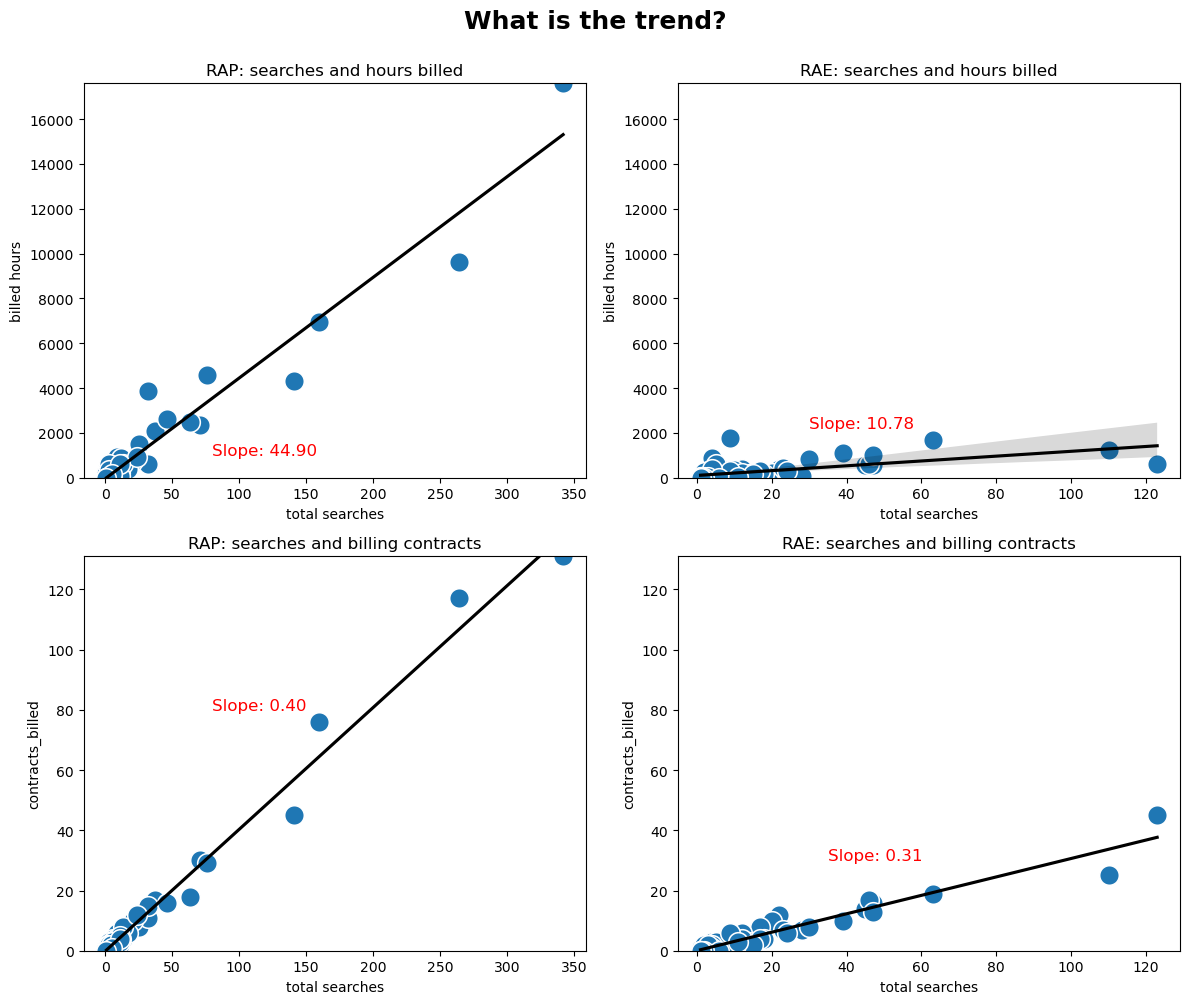

In [2074]:
# Plot total searches to billed hours

import numpy as np

# Define the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# RAP: searches to hours billed
scatter = sns.scatterplot(data=RAP_aggr_df, x='total searches', y='billed hours', s=200, ax=axes[0, 0])
axes[0, 0].set_title('RAP: searches and hours billed')
axes[0, 0].set_ylim(0, RAP_aggr_df['billed hours'].max()) 

# add a trendline
sns.regplot(data=RAP_aggr_df, x='total searches', y='billed hours', scatter=False, color='black', ci=None, ax=axes[0, 0])  

# Calculate slope and intercept
slope, intercept = np.polyfit(RAP_aggr_df['total searches'], RAP_aggr_df['billed hours'], 1)

# Display slope on the plot
axes[0, 0].text(80, 1000, f"Slope: {slope:.2f}", fontsize=12, color="red")



# RAE: searches to hours billed
scatter = sns.scatterplot(data=RAE_aggr_df, x='total searches', y='billed hours', s=200, ax=axes[0, 1])
axes[0, 1].set_title('RAE: searches and hours billed')
axes[0, 1].set_ylim(0, RAP_aggr_df['billed hours'].max())

# add a trendline
sns.regplot(data=RAE_aggr_df, x='total searches', y='billed hours', scatter=False, color='black', ci=95, ax=axes[0, 1])  

# Calculate slope and intercept
slope, intercept = np.polyfit(RAE_aggr_df['total searches'], RAE_aggr_df['billed hours'], 1)

# Display slope on the plot
axes[0, 1].text(30, 2200, f"Slope: {slope:.2f}", fontsize=12, color="red")


# RAP: searches to billing contracts
scatter = sns.scatterplot(data=RAP_aggr_df, x='total searches', y='contracts_billed', s=200, ax=axes[1, 0])
axes[1, 0].set_title('RAP: searches and billing contracts')
axes[1, 0].set_ylim(0, RAP_aggr_df['contracts_billed'].max()) 

# add a trendline
sns.regplot(data=RAP_aggr_df, x='total searches', y='contracts_billed', scatter=False, color='black', ci=None, ax=axes[1, 0])  

# Calculate slope and intercept
slope, intercept = np.polyfit(RAP_aggr_df['total searches'], RAP_aggr_df['contracts_billed'], 1)

# Display slope on the plot
axes[1, 0].text(80, 80, f"Slope: {slope:.2f}", fontsize=12, color="red")


# RAE: searches to billing contracts
scatter = sns.scatterplot(data=RAE_aggr_df, x='total searches', y='contracts_billed', s=200, ax=axes[1, 1])
axes[1, 1].set_title('RAE: searches and billing contracts')
axes[1, 1].set_ylim(0, RAP_aggr_df['contracts_billed'].max()) 

# add a trendline
sns.regplot(data=RAE_aggr_df, x='total searches', y='contracts_billed', scatter=False, color='black', ci=None, ax=axes[1, 1])  

# Calculate slope and intercept
slope, intercept = np.polyfit(RAE_aggr_df['total searches'], RAE_aggr_df['contracts_billed'], 1)

# Display slope on the plot
axes[1, 1].text(35, 30, f"Slope: {slope:.2f}", fontsize=12, color="red")

# Add a title to the figure
fig.suptitle('What is the trend?', 
             fontsize=18, fontweight='bold', y=1.0)  # Adjust y to place title higher

# Adjust layout
plt.tight_layout()
plt.show()

In [2076]:
# Extract IP from the dataset and create its own dataset
agg_RAE=aggr_df[aggr_df['Type of Case']!= 'Intellectual Property' ]

# creat IP dataset
agg_IP=aggr_df[aggr_df['Type of Case']== 'Intellectual Property' ]



In [2078]:
# how many expansion searches are contained in the IP dataset?
EXP_agg_IP=agg_IP[agg_IP['Division']=='Expansion']
EXP_agg_IP

,Division,Type of Case,Subject,type_subject,total searches,total contracts,contracts_billed,billed hours,avg billed hours to srches,avg billed hours to billed contracts
41,Expansion,Intellectual Property,Consumer Business,Intellectual Property: Consumer Business,3,2,2,133.05,44.35,66.525
42,Expansion,Intellectual Property,Industrial /Mechanical Design\nof Consumer Pro...,Intellectual Property: Industrial /Mechanical ...,1,0,0,0.00,0.00,NaN
43,Expansion,Intellectual Property,Pharmaceuticals,Intellectual Property: Pharmaceuticals,4,0,0,0.00,0.00,NaN
44,Expansion,Intellectual Property,Technology,Intellectual Property: Technology,3,2,2,313.68,104.56,156.840


In [2080]:
agg_RAE['total searches'].describe()

count    139.000000
mean       9.323741
std       16.823558
min        1.000000
25%        2.000000
50%        4.000000
75%        9.000000
max      123.000000
Name: total searches, dtype: float64

In [2082]:
agg_RAE=agg_RAE[agg_RAE['Division']=='Expansion']

In [2084]:
# limit the analysis to a specified number of searches. If a category has too few searches, it can skew the data analysis.
agg_RAE=agg_RAE[agg_RAE['total searches']>15]
agg_RAE

,Division,Type of Case,Subject,type_subject,total searches,total contracts,contracts_billed,billed hours,avg billed hours to srches,avg billed hours to billed contracts
2,Expansion,Class Action,Chemicals - Nonpharmaceuticals,Class Action: Chemicals - Nonpharmaceuticals,22,14,12,400.5000,18.204545,33.375000
3,Expansion,Class Action,Consumer Business,Class Action: Consumer Business,110,35,25,1258.1900,11.438091,50.327600
8,Expansion,Class Action,Financial,Class Action: Financial,63,20,19,1690.6100,26.835079,88.979474
9,Expansion,Class Action,Food/Beverage,Class Action: Food/Beverage,20,10,10,211.2000,10.560000,21.120000
11,Expansion,Class Action,Industrial /Mechanical Design\nof Consumer Pro...,Class Action: Industrial /Mechanical Design of...,17,8,8,223.6200,13.154118,27.952500
12,Expansion,Class Action,Insurance,Class Action: Insurance,45,14,14,587.8870,13.064156,41.991929
13,Expansion,Class Action,Medical,Class Action: Medical,24,11,6,165.7700,6.907083,27.628333
17,Expansion,Class Action,Technology,Class Action: Technology,47,18,16,558.2400,11.877447,34.890000
20,Expansion,Class Action,Transportation,Class Action: Transportation,28,8,7,93.3500,3.333929,13.335714
22,Expansion,Contract,Building and Construction,Contract: Building and Construction,23,7,7,423.1167,18.396378,60.445243


In [2086]:
agg_IP['total searches'].describe()


count     24.000000
mean      56.958333
std       87.470482
min        1.000000
25%        3.750000
50%       19.000000
75%       65.000000
max      342.000000
Name: total searches, dtype: float64

In [2088]:
# Expansion cases in the agg_IP will get fitered out by search limit

# limit the analysis to a specified number of searches. If a category has too few searches, it can skew the data analysis.
agg_IP=agg_IP[agg_IP['total searches']>29]

In [2090]:
agg_IP

,Division,Type of Case,Subject,type_subject,total searches,total contracts,contracts_billed,billed hours,avg billed hours to srches,avg billed hours to billed contracts
114,Patent,Intellectual Property,Biotechnology,Intellectual Property: Biotechnology,71,40,30,2360.6100,33.248028,78.687000
115,Patent,Intellectual Property,Building and Construction,Intellectual Property: Building and Construction,32,12,11,604.6700,18.895937,54.970000
116,Patent,Intellectual Property,Chemicals - Nonpharmaceuticals,Intellectual Property: Chemicals - Nonpharmace...,37,22,17,2063.5900,55.772703,121.387647
117,Patent,Intellectual Property,Consumer Business,Intellectual Property: Consumer Business,63,20,18,2504.1000,39.747619,139.116667
119,Patent,Intellectual Property,Electro Mechanical Design,Intellectual Property: Electro Mechanical Design,32,19,15,3869.4200,120.919375,257.961333
124,Patent,Intellectual Property,Industrial /Mechanical Design\nof Consumer Pro...,Intellectual Property: Industrial /Mechanical ...,141,54,45,4314.2900,30.597801,95.873111
126,Patent,Intellectual Property,Medical,Intellectual Property: Medical,160,87,76,6969.2504,43.557815,91.700663
127,Patent,Intellectual Property,Pharmaceuticals,Intellectual Property: Pharmaceuticals,264,151,117,9603.7603,36.377880,82.083421
129,Patent,Intellectual Property,Technology,Intellectual Property: Technology,342,171,131,17597.7379,51.455374,134.333877
130,Patent,Intellectual Property,Telecommunications,Intellectual Property: Telecommunications,76,31,29,4579.8150,60.260724,157.924655


In [2092]:
# Two datasets are:
    # agg_IP contains only case type 'Intellectual Property' filtered for total searches in each subject >12
    # agg_RAE contains only case types 'Tort', 'Class Action', 'Contract', and 'Unfiled' filtered for total searches in each subject >12
# not analyzing agg_smalldf (contains case types 'Criminal', 'Antitrust', 'False Claims Act') - too little data

In [2094]:
# check skewness of datasets for hours billed

print('agg_IP skewness data:  ')
print('billed hours: ', agg_IP['billed hours'].skew())
print('avg billed hours to srches: ',agg_IP['avg billed hours to srches'].skew())

print('\nagg_RAE skewness data:  ')
print('billed hours: ', agg_RAE['billed hours'].skew())
print('avg billed hours to srches: ',agg_RAE['avg billed hours to srches'].skew())


agg_IP skewness data:  
billed hours:  1.9812982553016323
avg billed hours to srches:  2.016117911787521

agg_RAE skewness data:  
billed hours:  1.1358110627222966
avg billed hours to srches:  0.5179783568775165


In [2096]:
# transform billed hours and avg billed hours to srches

from sklearn.preprocessing import PowerTransformer

# Apply Yeo-Johnson transformation to 'billed hours'
transformer = PowerTransformer(method='yeo-johnson')
agg_IP = agg_IP.copy()
agg_IP['yj_billed_hours'] = transformer.fit_transform(agg_IP[['billed hours']])

# Apply Yeo-Johnson transformation to 'avg billed hours to srches'
transformer = PowerTransformer(method='yeo-johnson')
agg_IP['yj_avg_billed_hours'] = transformer.fit_transform(agg_IP[['avg billed hours to srches']])

# Check agg_IP skewness for transformed columns
print('agg_IP skewness data:  ')
print('transformed billed hours: ', agg_IP['yj_billed_hours'].skew())
print('transformed avg billed hours to srches: ',agg_IP['yj_avg_billed_hours'].skew())

# Apply Yeo-Johnson transformation to 'billed hours'
transformer = PowerTransformer(method='yeo-johnson')
agg_RAE = agg_RAE.copy()
agg_RAE['yj_billed_hours'] = transformer.fit_transform(agg_RAE[['billed hours']])

# Apply Yeo-Johnson transformation to 'avg billed hours to srches'
transformer = PowerTransformer(method='yeo-johnson')
agg_RAE['yj_avg_billed_hours'] = transformer.fit_transform(agg_RAE[['avg billed hours to srches']])

# Check agg_RAE skewness for transformed columns
print('\nagg_RAE skewness data:  ')
print('transformed billed hours: ', agg_RAE['yj_billed_hours'].skew())
print('transformed avg billed hours to srches: ',agg_RAE['yj_avg_billed_hours'].skew())


agg_IP skewness data:  
transformed billed hours:  0.001038357965166323
transformed avg billed hours to srches:  -0.01295526810016066

agg_RAE skewness data:  
transformed billed hours:  -0.027461891868547014
transformed avg billed hours to srches:  -0.04851405875149184


In [1806]:
# the transformed data has improved skewness 

In [2098]:
from sklearn.preprocessing import StandardScaler

# Standardize the Yeo-Johnson transformed agg_IP data
agg_IP['standardized_yj_billed_hours'] = StandardScaler().fit_transform(agg_IP[['yj_billed_hours']])
agg_IP['standardized_yj_avg_billed_hours'] = StandardScaler().fit_transform(agg_IP[['yj_avg_billed_hours']])

# Standardize the Yeo-Johnson transformed Nan_agg_RAE data
agg_RAE['standardized_yj_billed_hours'] = StandardScaler().fit_transform(agg_RAE[['yj_billed_hours']])
agg_RAE['standardized_yj_avg_billed_hours'] = StandardScaler().fit_transform(agg_RAE[['yj_avg_billed_hours']])


In [2100]:
agg_IP['standardized_yj_billed_hours'].describe()


count    1.100000e+01
mean     1.009294e-17
std      1.048809e+00
min     -2.030489e+00
25%     -5.189749e-01
50%      2.303678e-02
75%      4.811594e-01
max      1.930619e+00
Name: standardized_yj_billed_hours, dtype: float64

In [2102]:
agg_RAE['standardized_yj_billed_hours'].describe()

count    1.800000e+01
mean    -3.700743e-17
std      1.028992e+00
min     -1.894615e+00
25%     -8.125064e-01
50%      7.369359e-02
75%      7.119068e-01
max      1.820112e+00
Name: standardized_yj_billed_hours, dtype: float64

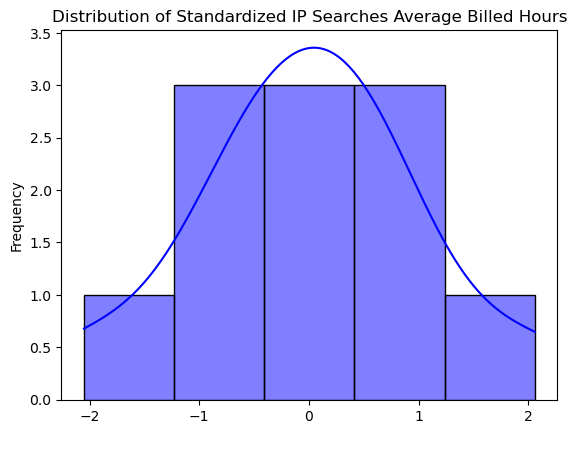

In [2104]:
import seaborn as sns

sns.histplot(agg_IP['standardized_yj_avg_billed_hours'], kde=True, color="blue")

plt.title("Distribution of Standardized IP Searches Average Billed Hours")
plt.xlabel(" ")
plt.ylabel("Frequency")

plt.show()

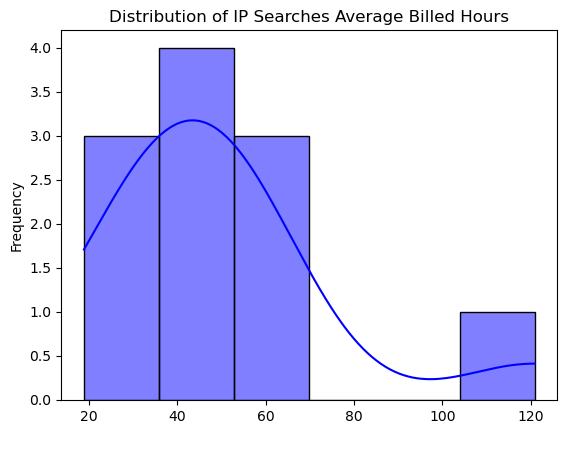

In [2106]:
sns.histplot(agg_IP['avg billed hours to srches'], kde=True, color="blue")

plt.title("Distribution of IP Searches Average Billed Hours")
plt.xlabel(" ")
plt.ylabel("Frequency")

plt.show()

In [2108]:
agg_IP

,Division,Type of Case,Subject,type_subject,total searches,total contracts,contracts_billed,billed hours,avg billed hours to srches,avg billed hours to billed contracts,yj_billed_hours,yj_avg_billed_hours,standardized_yj_billed_hours,standardized_yj_avg_billed_hours
114,Patent,Intellectual Property,Biotechnology,Intellectual Property: Biotechnology,71,40,30,2360.6100,33.248028,78.687000,-0.552780,-0.640330,-0.552780,-0.640330
115,Patent,Intellectual Property,Building and Construction,Intellectual Property: Building and Construction,32,12,11,604.6700,18.895937,54.970000,-2.030489,-2.050816,-2.030489,-2.050816
116,Patent,Intellectual Property,Chemicals - Nonpharmaceuticals,Intellectual Property: Chemicals - Nonpharmace...,37,22,17,2063.5900,55.772703,121.387647,-0.705706,0.527092,-0.705706,0.527092
117,Patent,Intellectual Property,Consumer Business,Intellectual Property: Consumer Business,63,20,18,2504.1000,39.747619,139.116667,-0.485170,-0.224009,-0.485170,-0.224009
119,Patent,Intellectual Property,Electro Mechanical Design,Intellectual Property: Electro Mechanical Design,32,19,15,3869.4200,120.919375,257.961333,0.023037,2.060042,0.023037,2.060042
124,Patent,Intellectual Property,Industrial /Mechanical Design\nof Consumer Pro...,Intellectual Property: Industrial /Mechanical ...,141,54,45,4314.2900,30.597801,95.873111,0.152813,-0.838845,0.152813,-0.838845
126,Patent,Intellectual Property,Medical,Intellectual Property: Medical,160,87,76,6969.2504,43.557815,91.700663,0.737820,-0.016059,0.737820,-0.016059
127,Patent,Intellectual Property,Pharmaceuticals,Intellectual Property: Pharmaceuticals,264,151,117,9603.7603,36.377880,82.083421,1.141166,-0.428794,1.141166,-0.428794
129,Patent,Intellectual Property,Technology,Intellectual Property: Technology,342,171,131,17597.7379,51.455374,134.333877,1.930619,0.352992,1.930619,0.352992
130,Patent,Intellectual Property,Telecommunications,Intellectual Property: Telecommunications,76,31,29,4579.8150,60.260724,157.924655,0.224498,0.691688,0.224498,0.691688


In [2176]:
agg_IP['avg billed hours to srches'].describe()

count     11.000000
mean      49.787015
std       26.782571
min       18.895937
25%       34.812954
50%       43.557815
75%       56.298308
max      120.919375
Name: avg billed hours to srches, dtype: float64

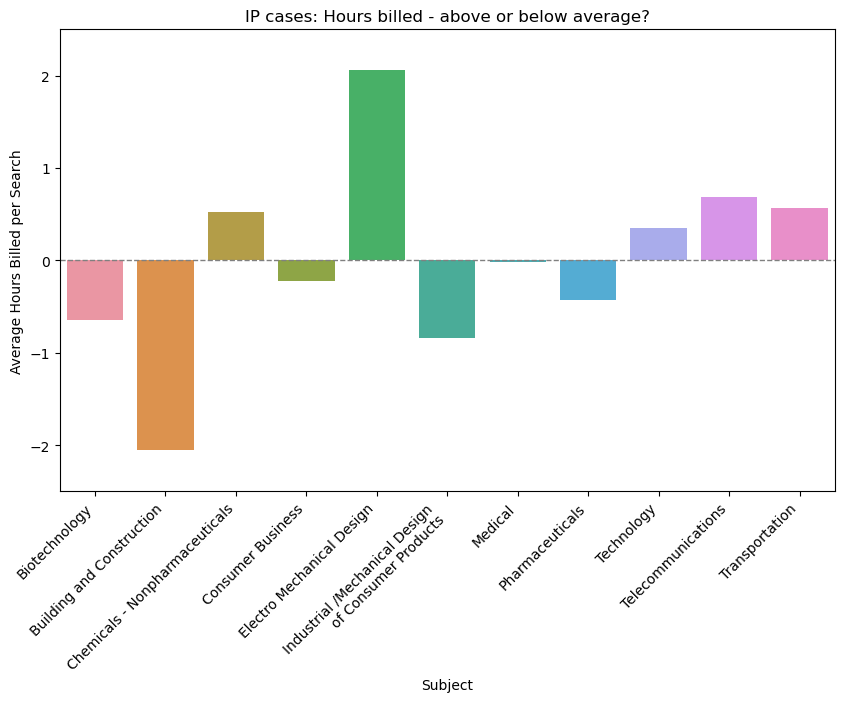

In [2112]:
# ** Look at IP data: agg_IP **

# use transformed data to compare hours across type of case
# y=0 represents the mean of the dataset 

import matplotlib.pyplot as plt
import seaborn as sns

# Create a barplot across subject comparing avg hours billed
plt.figure(figsize=(10, 6))
sns.barplot(x='Subject', y='standardized_yj_avg_billed_hours', data=agg_IP)

# Add a horizontal line at y=0
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Set title and labels
plt.title('IP cases: Hours billed - above or below average?')

plt.ylabel('Average Hours Billed per Search')
plt.ylim(-2.5,2.5)
plt.xticks(rotation=45, ha='right')

# Save the figure to a file
plt.savefig('IP_stndbarplot_avg_hours_billed_by_subject.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


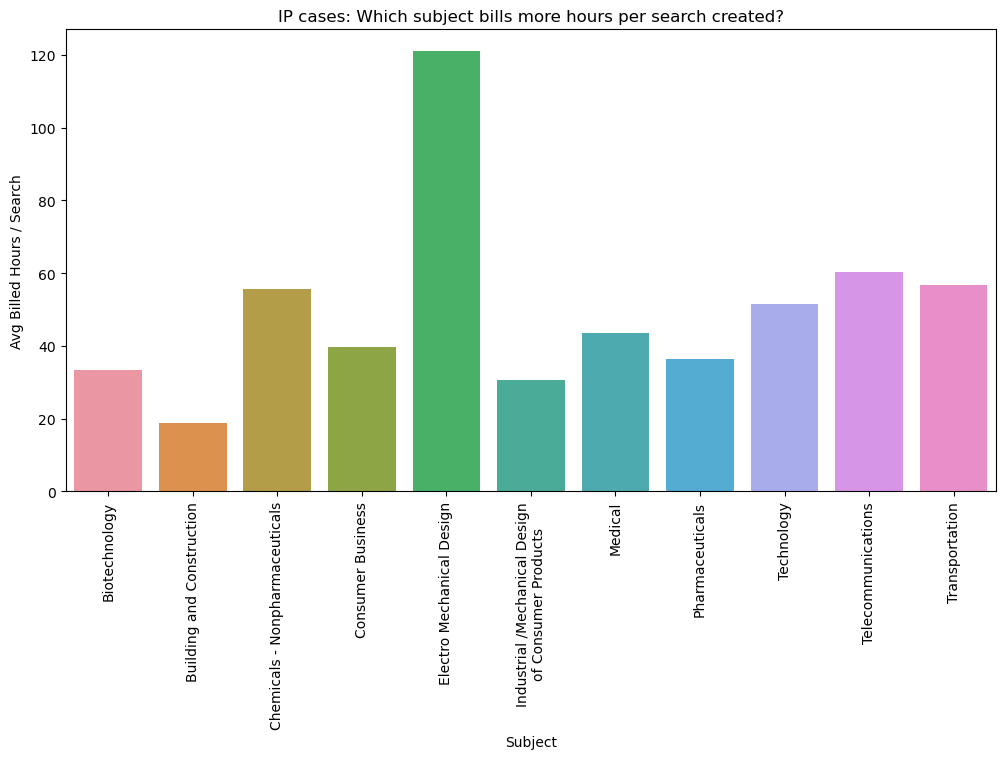

In [2120]:
# import textwrap

# Bar plot of avg billed hours per search
plt.figure(figsize=(12, 6))
sns.barplot(data=agg_IP, x='Subject', y='avg billed hours to srches', errorbar=None)
plt.title('IP cases: Which subject bills more hours per search created?')
plt.ylabel('Avg Billed Hours / Search')
plt.xticks(rotation=90)

# Save the figure to a file
plt.savefig('IP_barplot_avg_hours_billed_by_subject.png', format='png', dpi=300, bbox_inches='tight')

plt.show()


In [2126]:
# look at agg_RAE which contains Tort, Contract, and Class Action (Unfiled has too few searches)
agg_RAE

,Division,Type of Case,Subject,type_subject,total searches,total contracts,contracts_billed,billed hours,avg billed hours to srches,avg billed hours to billed contracts,yj_billed_hours,yj_avg_billed_hours,standardized_yj_billed_hours,standardized_yj_avg_billed_hours
2,Expansion,Class Action,Chemicals - Nonpharmaceuticals,Class Action: Chemicals - Nonpharmaceuticals,22,14,12,400.5000,18.204545,33.375000,-0.177921,0.543095,-0.177921,0.543095
3,Expansion,Class Action,Consumer Business,Class Action: Consumer Business,110,35,25,1258.1900,11.438091,50.327600,1.383831,-0.377602,1.383831,-0.377602
8,Expansion,Class Action,Financial,Class Action: Financial,63,20,19,1690.6100,26.835079,88.979474,1.820112,1.486062,1.820112,1.486062
9,Expansion,Class Action,Food/Beverage,Class Action: Food/Beverage,20,10,10,211.2000,10.560000,21.120000,-0.967597,-0.515782,-0.967597,-0.515782
11,Expansion,Class Action,Industrial /Mechanical Design\nof Consumer Pro...,Class Action: Industrial /Mechanical Design of...,17,8,8,223.6200,13.154118,27.952500,-0.899386,-0.122255,-0.899386,-0.122255
12,Expansion,Class Action,Insurance,Class Action: Insurance,45,14,14,587.8870,13.064156,41.991929,0.323716,-0.135205,0.323716,-0.135205
13,Expansion,Class Action,Medical,Class Action: Medical,24,11,6,165.7700,6.907083,27.628333,-1.251818,-1.163743,-1.251818,-1.163743
17,Expansion,Class Action,Technology,Class Action: Technology,47,18,16,558.2400,11.877447,34.890000,0.254826,-0.310472,0.254826,-0.310472
20,Expansion,Class Action,Transportation,Class Action: Transportation,28,8,7,93.3500,3.333929,13.335714,-1.894615,-1.987502,-1.894615,-1.987502
22,Expansion,Contract,Building and Construction,Contract: Building and Construction,23,7,7,423.1167,18.396378,60.445243,-0.107439,0.566346,-0.107439,0.566346


In [2180]:
agg_RAE['avg billed hours to srches'].describe()

count    18.000000
mean     14.961457
std       7.480557
min       3.333929
25%      10.779523
50%      13.061869
75%      18.348420
max      28.442051
Name: avg billed hours to srches, dtype: float64

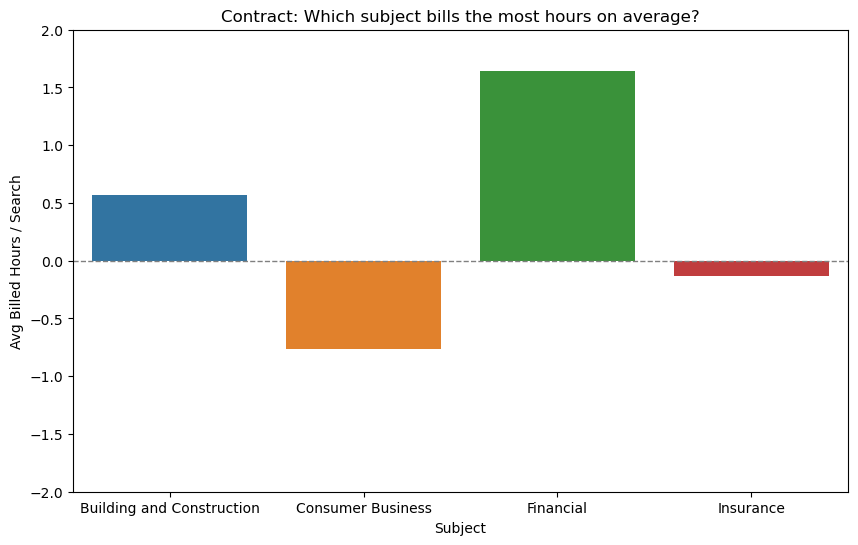

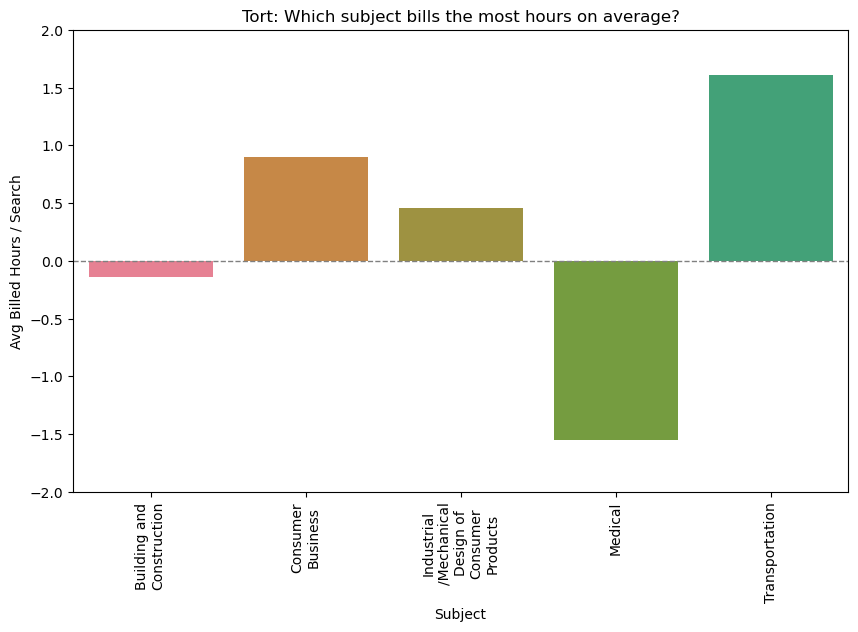

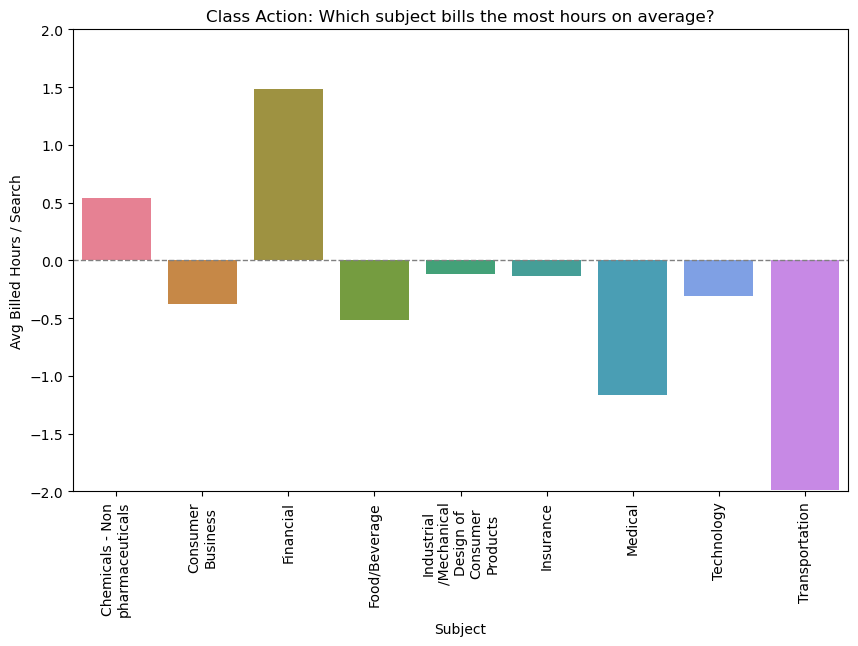

In [2166]:
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# Define the figure and axes
# fig, axes = plt.subplots(2, 2, figsize=(20, 8), sharey=True)

# Define color palette
# palette = sns.color_palette("husl", len(agg_RAE['Subject'].unique()))

# create a dataset for each type of case
contract=agg_RAE[(agg_RAE['Type of Case']=='Contract')]
class_action=agg_RAE[agg_RAE['Type of Case']=='Class Action']
tort=agg_RAE[agg_RAE['Type of Case']=='Tort']

# Create a barplot for contract across subject comparing avg hours billed
plt.figure(figsize=(10, 6))
sns.barplot(data=contract, x='Subject', y='standardized_yj_avg_billed_hours')

# Add a horizontal line at y=0
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.title('Contract: Which subject bills the most hours on average?')
# labels = contract['Subject'].unique()
# wrapped_labels = [textwrap.fill(label, 15) for label in labels]  # Wrap text at 15 characters
# plt.xticks(ticks=range(len(labels)), labels=wrapped_labels, rotation=90)
# plt.xticks(ticks=range(len(contract['Subject'].unique())), labels=contract['Subject'], rotation=90)
plt.ylabel('Avg Billed Hours / Search')
plt.ylim(-2,2)

# save file
plt.savefig('Contract_stndbarplot_avg_hours_billed_by_subject.pdf', format='png', dpi=300, bbox_inches='tight')


# Create a barplot for Tort across subject comparing avg hours billed
plt.figure(figsize=(10, 6))
sns.barplot(data=tort, x='Subject', y='standardized_yj_avg_billed_hours', palette = palette)

# Add a horizontal line at y=0
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.title('Tort: Which subject bills the most hours on average?')
labels = tort['Subject'].unique()
wrapped_labels = [textwrap.fill(label, 15) for label in labels]  # Wrap text at 15 characters
plt.xticks(ticks=range(len(labels)), labels=wrapped_labels, rotation=90)
plt.ylabel('Avg Billed Hours / Search')
plt.ylim(-2,2)

# save file
plt.savefig('Tort_stndbarplot_avg_hours_billed_by_subject.png', format='png', dpi=300, bbox_inches='tight')


# Create a barplot for Class Action across subject comparing avg hours billed
plt.figure(figsize=(10, 6))
sns.barplot(data=class_action, x='Subject', y='standardized_yj_avg_billed_hours', palette = palette)

# Add a horizontal line at y=0
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.title('Class Action: Which subject bills the most hours on average?')
plt.ylabel('Avg Billed Hours / Search')
plt.ylim(-2,2)
labels = class_action['Subject'].unique()
wrapped_labels = [textwrap.fill(label, 15) for label in labels]  # Wrap text at 15 characters
plt.xticks(ticks=range(len(labels)), labels=wrapped_labels, rotation=90)  

# save file
plt.savefig('ClassAction_stndbarplot_avg_hours_billed_by_subject.png', format='png', dpi=300, bbox_inches='tight')


# Adjust layout
# plt.tight_layout()
plt.show()


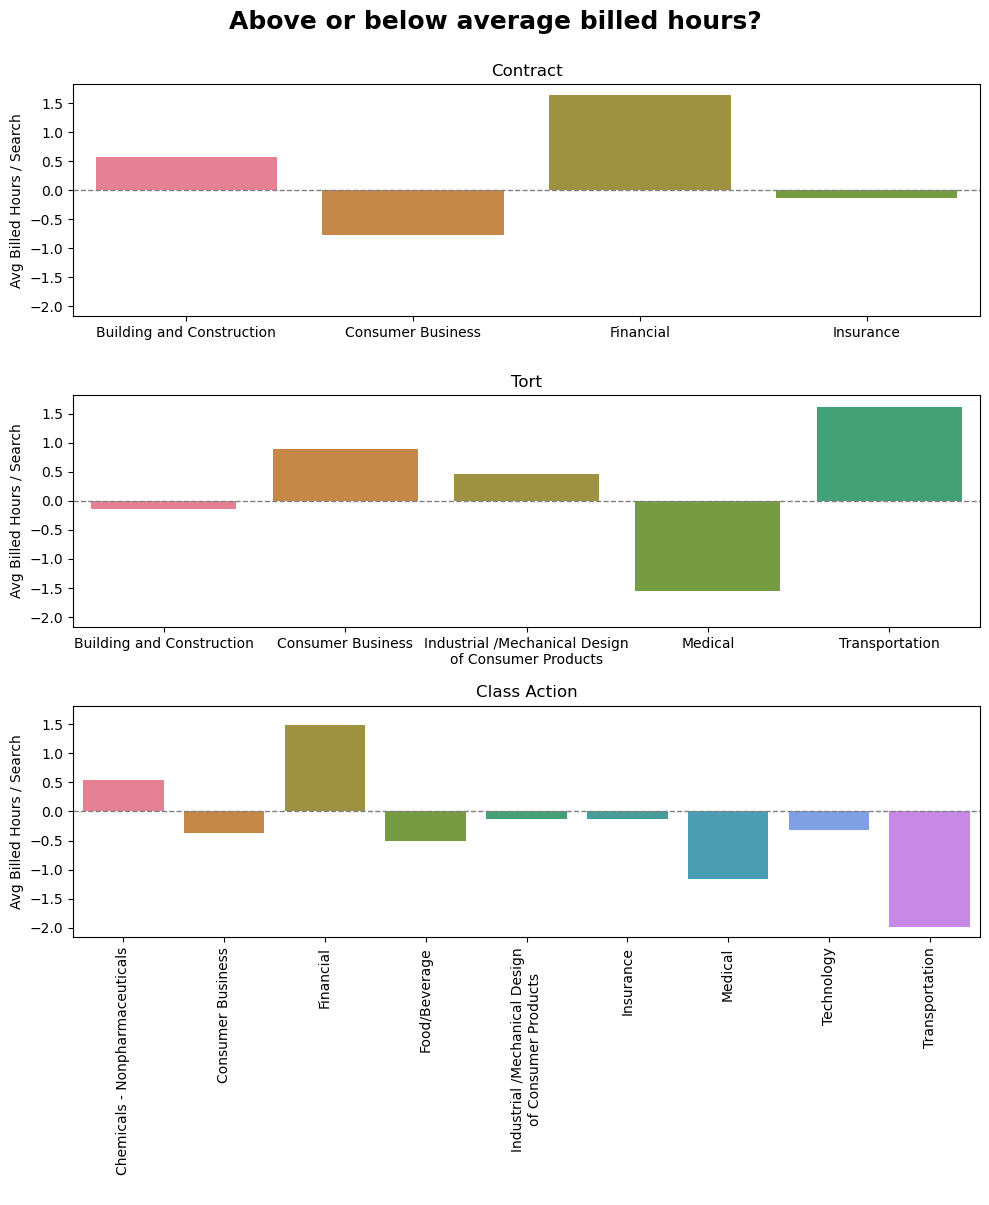

In [2154]:
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# Define the figure and axes
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharey=True)

# Define color palette
palette = sns.color_palette("husl", len(agg_RAE['Subject'].unique()))

# create a dataset for each type of case
contract = agg_RAE[agg_RAE['Type of Case'] == 'Contract']
class_action = agg_RAE[agg_RAE['Type of Case'] == 'Class Action']
tort = agg_RAE[agg_RAE['Type of Case'] == 'Tort']

# Plot for Contract
sns.barplot(data=contract, x='Subject', y='standardized_yj_avg_billed_hours', palette=palette, ax=axes[0])
axes[0].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[0].set_title('Contract')
axes[0].set_ylabel('Avg Billed Hours / Search')
axes[0].set_xlabel(' ')

# Plot for Tort
sns.barplot(data=tort, x='Subject', y='standardized_yj_avg_billed_hours', palette=palette, ax=axes[1])
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[1].set_title('Tort')
axes[1].set_ylabel('Avg Billed Hours / Search')
axes[1].set_xlabel('') 

# Plot for Class Action
sns.barplot(data=class_action, x='Subject', y='standardized_yj_avg_billed_hours', palette=palette, ax=axes[2])
axes[2].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[2].set_title('Class Action')
axes[2].set_ylabel('Avg Billed Hours / Search')
axes[2].set_xticklabels(labels=class_action['Subject'],rotation=90)
axes[2].set_xlabel(' ')



# Add a title to the figure
fig.suptitle('Above or below average billed hours?', 
             fontsize=18, fontweight='bold', y=1.0)  # Adjust y to place title higher

# Adjust layout
plt.tight_layout()
plt.show()


In [556]:
Antitrust

,Type of Case,Subject,Division,total searches,total contracts,contracts_billed,billed hours,avg billed hours to srches,avg billed hours to billed contracts,yj_billed_hours,yj_avg_billed_hours,standardized_yj_billed_hours,standardized_yj_avg_billed_hours
3,Antitrust,Consumer Business,Expansion,5,1,1,79.60,15.920000,79.6000,-0.394225,-0.820825,-0.394225,-0.820825
7,Antitrust,Industrial /Mechanical Design of Consumer Prod...,Expansion,1,1,1,281.00,281.000000,281.0000,0.762325,1.044949,0.762325,1.044949
8,Antitrust,Industrial /Mechanical Design of Consumer Prod...,Patent,1,1,1,456.25,456.250000,456.2500,1.341365,1.395006,1.341365,1.395006
10,Antitrust,Medical,Patent,5,2,1,50.00,10.000000,50.0000,-0.717870,-1.082179,-0.717870,-1.082179
12,Antitrust,Pharmaceuticals,Patent,11,5,4,271.35,24.668182,67.8375,0.723824,-0.562017,0.723824,-0.562017
13,Antitrust,Technology,Patent,2,1,1,50.75,25.375000,50.7500,-0.708230,-0.544944,-0.708230,-0.544944
